In [1]:
import numpy as np
import xarray as xr
import os

## Loading a dataset
Update `rootdir` with your own dataset's path. All relevant variables will be loaded into `ds` and the (static) grid data will be loaded into a separate dataset. Note that the time period (`tprd`) is `'201001-201412'` such that only the last five years of the CM4 historical run are used. In order to include more years, you can use wildchard `*` for `tprd` instead.

In [2]:
rootdir = '/data_cmip6/CMIP6'
activity_id = 'CMIP'
institution_id = 'NOAA-GFDL'
source_id = 'GFDL-CM4'
experiment_id = 'historical'
member_id = 'r1i1p1f1'
table_id = 'Omon'
grid_label = 'gn'
version = 'v20180701'
tprd = '201001-201412'
#tprd = '*'

ncdir = os.path.join(rootdir,activity_id,institution_id,source_id,experiment_id,member_id,table_id)

For surface WMT we only need the surface tracer fields (SST and SSS) and fluxes. See the list of variables with a description below. In this tutorial we are focusing on the total fluxes of heat and freshwater. `xwmt` also includes the calculations of WMT due to salt fluxes. However, the corresponding diagnostics (`sfdsi`) might not be available. The good news is that this is usually a minor term in the surface WMT calculation and can be set to zero (if not availalble). 
- `tos`: Sea Surface Temperature (units: degC)
> Temperature of upper boundary of the liquid ocean, including temperatures below sea-ice and floating ice shelves.
- `sos`: Sea Surface Salinity (units: 0.001) 
> Sea water salinity is the salt content of sea water, often on the Practical Salinity Scale of 1978. However, the unqualified term 'salinity' is generic and does not necessarily imply any particular method of calculation. The units of salinity are dimensionless and the units attribute should normally be given as 1e-3 or 0.001 i.e. parts per thousand. 
- `hfds`: Downward Heat Flux at Sea Water Surface (units: W m-2)
> This is the net flux of heat entering the liquid water column through its upper surface (excluding any "flux adjustment").
- `wfo`: Water Flux into Sea Water (units: kg m-2 s-1)
> Computed as the water flux into the ocean divided by the area of the ocean portion of the grid cell. This is the sum *wfonocorr* and *wfcorr*.
- `sfdsi`: Downward Sea Ice Basal Salt Flux (units: kg m-2 s-1)
> This field is physical, and it arises since sea ice has a nonzero salt content, so it exchanges salt with the liquid ocean upon melting and freezing.

In [3]:
variables = ['tos','sos','hfds','wfo','sfdsi']
#dss = []
ds = xr.Dataset()
for var in variables:
    filepath = os.path.join(ncdir,var,grid_label,version)
    filename = '_'.join([var,table_id,source_id,experiment_id,member_id,grid_label,tprd])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        #dss.append(xr.open_mfdataset(filepath+'/'+filename,use_cftime=True))
        ds[var] = xr.open_mfdataset(filepath+'/'+filename,use_cftime=True)[var]
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading tos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading sos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading hfds_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading wfo_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Path for sfdsi does not exist. Skipping.


Besides the surface fields , `xwmt` also requires latitude, logitude and the cell area (`areacello`). We also will load the bathymetry (`deptho`) and ocean basin mask (`basin`) so we can subsample the datast by ocean depth and basins.

In [4]:
grid = []
for var in ['areacello','deptho','basin']:
    filepath = os.path.join(ncdir.replace(table_id,'Ofx'),var,grid_label,version)
    filename = '_'.join([var,'Ofx',source_id,experiment_id,member_id,grid_label])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        grid.append(xr.open_mfdataset(filepath+'/'+filename,use_cftime=True))
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading areacello_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading deptho_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading basin_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc


Now we can combine the variable and grid info and set the dimension and coordinate names to a common standard. In the case for CM4, there are inconsistencies in the static file for `arecello` (the dimension names are not common CMOR standard). So we need to rename the dimensions first in order to have consistency among the loaded data arrays before combining them.

In [5]:
#ds = xr.merge(dss+grid[1:])
ds = xr.merge([ds, xr.merge(grid[1:])])

# Area needs to be loaded seperately after renaming MOM6-specific dimension names (xh, yh) 
ds['areacello'] = grid[0].areacello.rename({'xh': 'x', 'yh': 'y'})

`xwmt` requires a land mask with the name `wet` that has values of 1 for ocean and 0 for land. In  most cases, model output fields already have the land masked out. Having a seperate land mask helps to avoid any potential issues due to various ways of defining missing values (e.g., -999 vs. 0 vs. NaN). Here we use the bathymetry file `deptho` to define land where `deptho` is NaN. It is recommended to check how land is defined in your model-specifc output and then generate `wet` accordingly.

In [6]:
# Create land mask "wet" from deptho
ds['wet'] = xr.where(~np.isnan(ds.deptho),1,0)
# wet is 1 for ocean and 0 for land

The wmt package expects a variable name `sfdsi` for the salt flux. In the case `sfdsi` is not available, we can create an array with all zeros having the same dimensions as the other flux fields (`hfds`, `wfo`). 

In [7]:
# Create an all-zero data array for sfdsi (when it is missing)
if not 'sfdsi' in ds:
    print('sfdsi is missing: Add all-zero field for sfdsi based on hfds')
    ds['sfdsi'] = xr.zeros_like(ds['hfds']).rename('sfdsi')
    # Remove all attributes
    ds['sfdsi'].attrs = {}

sfdsi is missing: Add all-zero field for sfdsi based on hfds


The first step is to initialize the class by creating an object. This object includes all the calculations for surface WMT (`swmt`) and full 3D WMT (`wmt`). Since we use here surface fluxes, we will use the `swmt` class.

In [8]:
from xwmt.swmt import swmt

The `swmt` class object includes multiple functions to look at the relevant data. The most common function is `.G()` which gives you the WMT along $\lambda$ (i.e., $G(\lambda)$). Here, we need to define $\lambda$. For example, 'theta' for potential temperature ($\theta$) or 'sigma0' for potential density referenced at 0 dbar ($\sigma_0$). We can use command `.lambdas()` for a list of available $\lambda$'s. Here, we will go with $\sigma_0$. This is all you need, but if you want to define the size of the bins you can do that with the argument `bin`.

In [9]:
lstr='sigma0'

if lstr == 'sigma0':
    lmin = 10
    lmax = 30
    dl = 0.1
elif lstr == 'theta':
    lmin = -2
    lmax = 30
    dl = 0.5
elif lstr == 'salt':
    lmin = 20
    lmax = 40
    dl = 0.1

Before initialize the `swmt` class from the dataset we can subsample the global field by basin or any other masking (e.g., by basin). You can define your own region based on some mask or coordinate ranges. However, if you want to compare to available WMT estimates from ECCOv4 and ERA5, the subsampling should be done using the CMIP basin mask. The regional subsetting with the CMIP basin mask uses the mask `basin`, which is included in the dataset `ds`, and setting `basin_name` to any of the following options: *arctic*, *atlantic*, *baltic*, *black*, *global*, *hudson*, *indian*, *mediterranean*, *pacific*, *persian*, *red*, *southern*. In the case of Atlantic (`basin_name = 'atlantic'`) and Pacific (`basin_name = 'pacific'`), reanalysis estimates are also available for the tropical (*atlantic_tropc*, *pacific_tropc*), subtropical (*atlantic_subtN*, *atlantic_subtS*, *pacific_subtN*, *pacific_subtS*) and subpolar regions (*atlantic_subpN*, *pacific_subpN*), based on the following criteria:
```
if basin_name[-6:]=='_tropc':
    mask = mask & (ds["lat"]<=20) & (ds["lat"]>=-20)
if basin_name[-6:]=='_subtN':
    mask = mask & (ds["lat"]<=45) & (ds["lat"]>20)
if basin_name[-6:]=='_subpN':
    mask = mask & (ds["lat"]>45)
if basin_name[-6:]=='_subtS':
    mask = mask & (ds["lat"]>=-45) & (ds["lat"]<-20)
```

In [10]:
basin_name = 'pacific_tropc' # global, atlantic, indian, pacific, southern, arctic
# atlantic_subpN,  pacific_tropc
bidx = [item.split('_')[0] for item in ds.basin.flag_meanings.split(' ')].index(basin_name.split('_')[0])

if basin_name=='global':
    mask = xr.where(ds.basin==bidx,0,1)
else:
    mask = ds.basin==bidx

In [11]:
if basin_name[-6:]=='_tropc':
    mask = mask & (ds["lat"]<=20) & (ds["lat"]>=-20)
if basin_name[-6:]=='_subtN':
    mask = mask & (ds["lat"]<=45) & (ds["lat"]>20)
if basin_name[-6:]=='_subpN':
    mask = mask & (ds["lat"]>45)
if basin_name[-6:]=='_subtS':
    mask = mask & (ds["lat"]>=-45) & (ds["lat"]<-20)

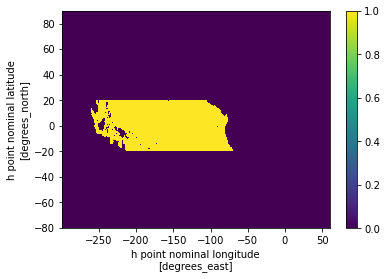

In [12]:
mask.plot()

In [13]:
group_tend=False
G = swmt(ds.where(mask)).G(lstr, bins=np.arange(lmin,lmax,dl),group_tend=group_tend)
da = xr.zeros_like(G[list(G.keys())[0]]).rename('total')
for tend in G.keys():
    da += G[tend]
G['total'] = da

In [14]:
yr_st = str(G.time.dt.year[0].values)
yr_ed = str(G.time.dt.year[-1].values)

In [15]:
# Load the corresponding WMT datasets (dset) generated from ECCOv4 and ERA5 reanalysis
dset_dir = '/home/Graeme.Macgilchrist/wmt/'

ddict = {}
for dset in ['ecco.ecco','era5.en4']:
    filepath = os.path.join(dset_dir,dset.split('.')[0])
    filename = '-'.join([dset+'.G',lstr,basin_name])+'.nc'
    print('Loading',filename)
    dset_ds = xr.open_dataset(filepath+'/'+filename).sel(time=slice(yr_st,yr_ed))
    
    da = xr.zeros_like(dset_ds[list(dset_ds.keys())[0]]).rename('total')
    for tend in dset_ds.keys():
        da += dset_ds[tend]
        
    dset_ds['total'] = da
    ddict[dset.split('.')[0]] = dset_ds.mean('time')

Loading ecco.ecco.G-sigma0-pacific_tropc.nc
Loading era5.en4.G-sigma0-pacific_tropc.nc


In [16]:
import matplotlib.pyplot as plt

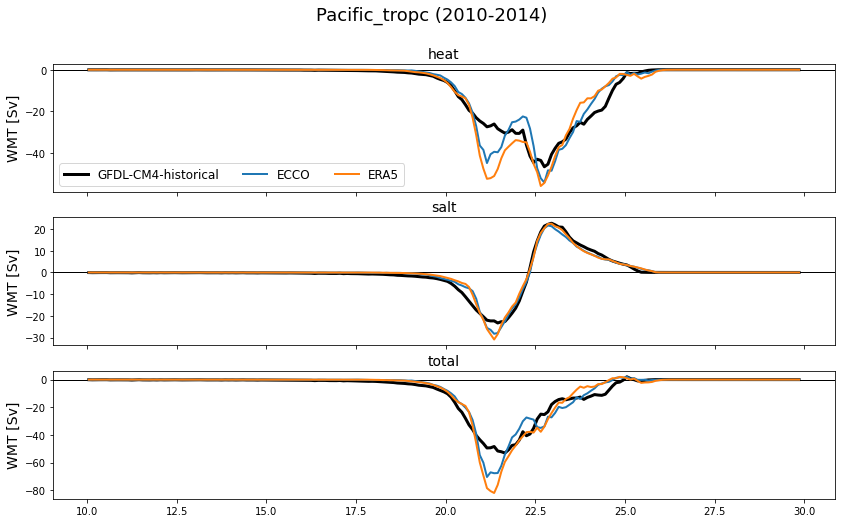

In [17]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(14,8))

for i, ten in enumerate(G.keys()):
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    axs[i].plot(G[lstr], G.mean('time')[ten]*1e-6, c='k', lw=3, ls='-',
                label='-'.join([source_id,experiment_id]))
    for dset in ddict:
        axs[i].plot(ddict[dset][lstr], ddict[dset][ten]*1e-6, lw=2, linestyle='-', label=dset.upper())
    axs[i].set_ylabel('WMT [Sv]',fontsize=14)
    axs[i].set_title(ten,fontsize=14)
    if i==0:
        axs[i].legend(loc='lower left',ncol=3,fontsize=12)

fig.suptitle(basin_name.capitalize()+' (%s-%s)'%(yr_st,yr_ed),fontsize=18)
plt.show()

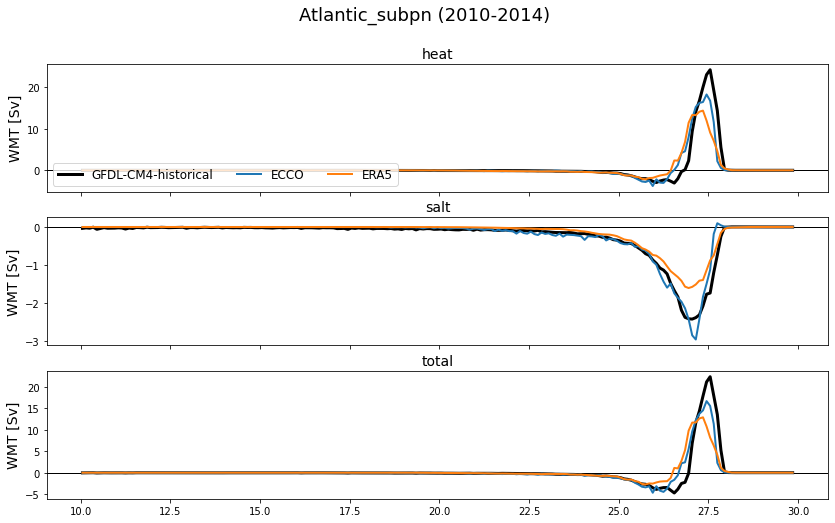

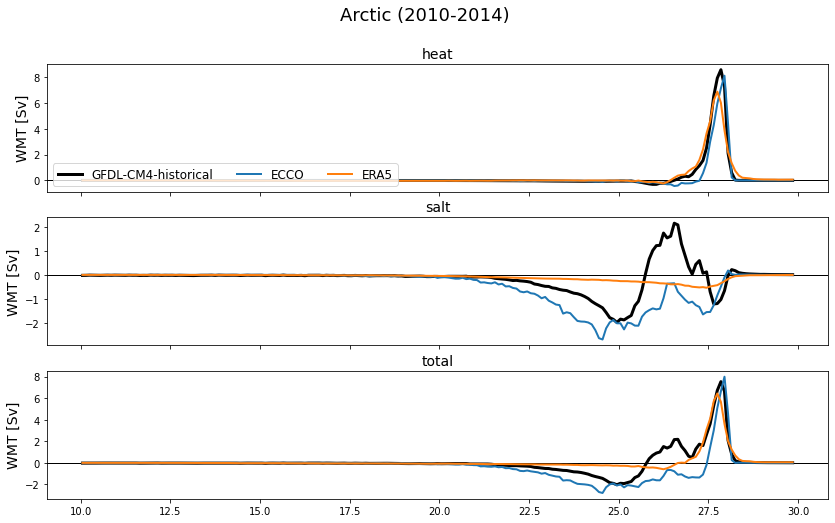

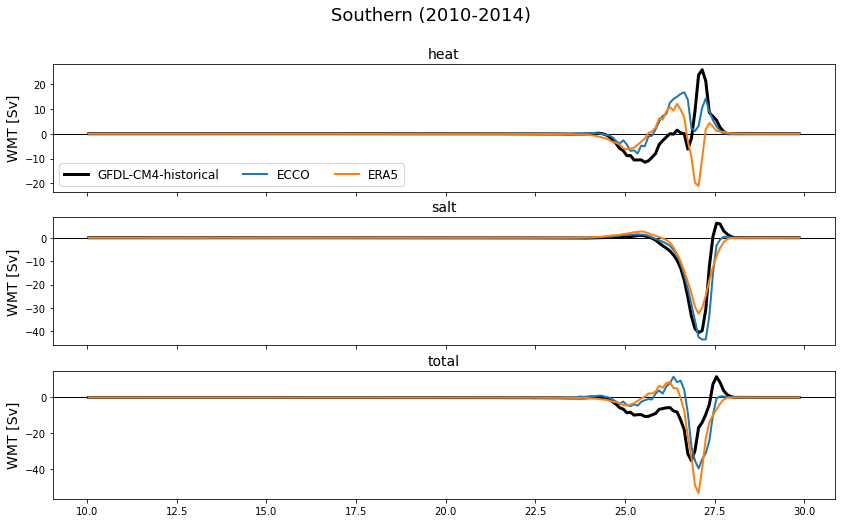

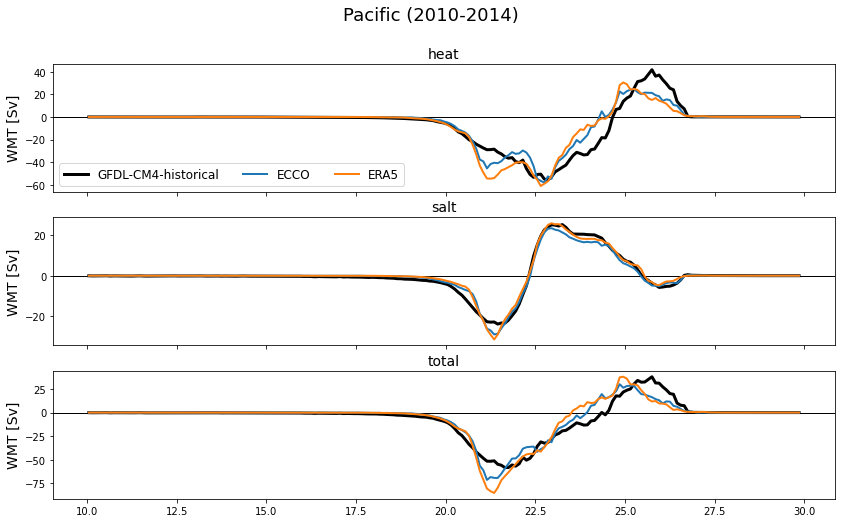

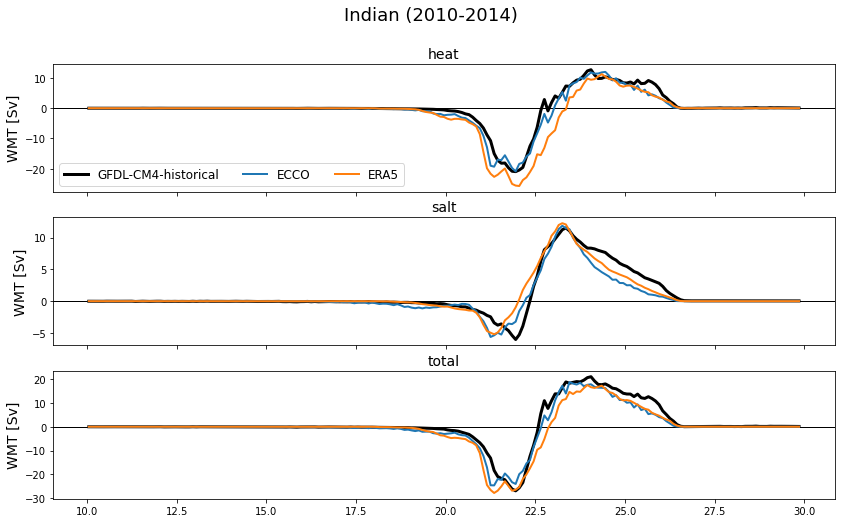

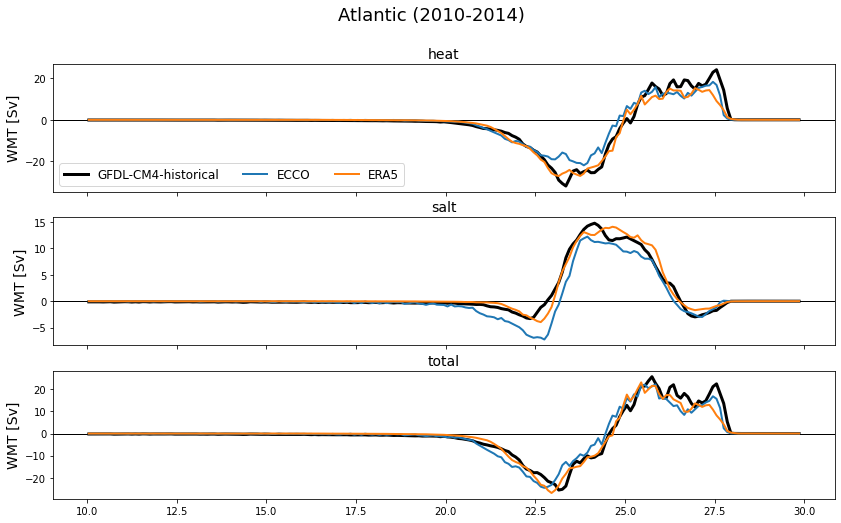

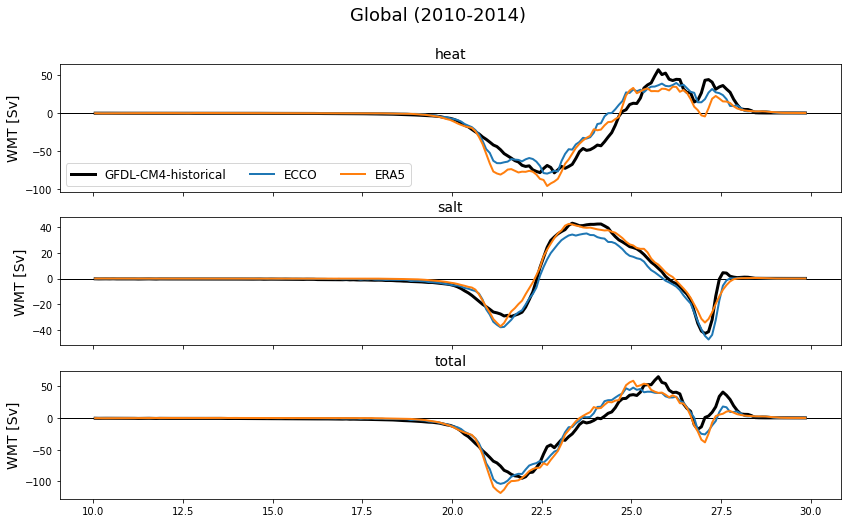